In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta
!pip install xlrd

TO_DATE = datetime.today().strftime('%Y-%m-%d')
FROM_DATE = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
MODEL = 'gpt-4-turbo'

FROM_DATE, TO_DATE

('2024-04-10', '2024-05-10')

### II. Election Forecasting

In [ ]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class TimeSeriesDataProcessor():
   def __init__(self, data, source_data, transforms=None):
        self.data = pd.DataFrame(data)
        self.source_data = source_data
        self.transforms = transforms

   def process_data(self, source_data):
        if source_data == "polls":
          self.data = self.data[self.data.candidate_name.str.contains("Biden")]
          self.data['start_date'] = pd.to_datetime(self.data['start_date'])
          self.data['end_date'] = pd.to_datetime(self.data['end_date'])
          self.data['ds'] = pd.to_datetime(self.data.start_date + ((self.data.end_date - self.data.start_date)/2))
          self.data['unique_id'] = self.data.poll_id
          self.data['y'] = self.data[self.data.pct > 10].pct
        else:
          self.data = self.data[self.data.politician.str.contains("Biden")]
          self.data['start_date'] = pd.to_datetime(self.data['start_date'])
          self.data['end_date'] = pd.to_datetime(self.data['end_date'])
          self.data['ds'] = pd.to_datetime(self.data.start_date + ((self.data.end_date - self.data.start_date)/2))
          self.data['unique_id'] = self.data.poll_id
          self.data['y'] = self.data[self.data.yes > 10].yes

        self.data = self.data[['ds', 'unique_id', 'y']]
        self.data.sort_values(by='ds', inplace=True)
        self.data = self.synthesize_data(self.data)
        self.data = TimeSeries.from_dataframe(self.data, time_col='ds', freq='D')
        train, test = self.train_test_split(self.data)
        self.data_plot(train, "train data")
        self.data_plot(test, "test data")
        self.data_plot(self.data, "all data")

        return self.data, train, test

   def synthesize_data(self, data):
        self.data = data.groupby('ds').agg({'y': 'mean'}).sort_values(by='ds').reset_index()
        self.data.set_index('ds', inplace=True)
        self.data = self.data.resample('D').ffill()
        self.data.reset_index(inplace=True)

        return self.data

   def train_test_split(self, data):
        train, test = data[:-120], data[-120:]
        return train, test

   def data_plot(self, data, dataset_type):
        if dataset_type in ["train data", "test data"]:
            data.plot(new_plot=False, central_quantile=0.5, low_quantile=0.05, high_quantile=0.95, default_formatting=True, label=f'{dataset_type} data')
        else:
            data.plot(new_plot=True, central_quantile=0.5, low_quantile=0.05, high_quantile=0.95, default_formatting=True, label=f'{dataset_type} data')

   def __getitem__(self, idx):
        row = self.data.iloc[idx]
        content = self.get_content(row['url'])
        row['content'] = content.replace('\n', ' ')
        if self.transforms:
            row = self.transforms(row)
        return row

In [ ]:
time_data = pd.read_csv('president_polls.csv')

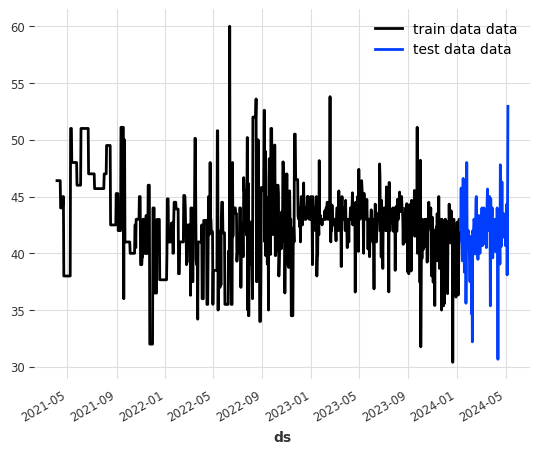

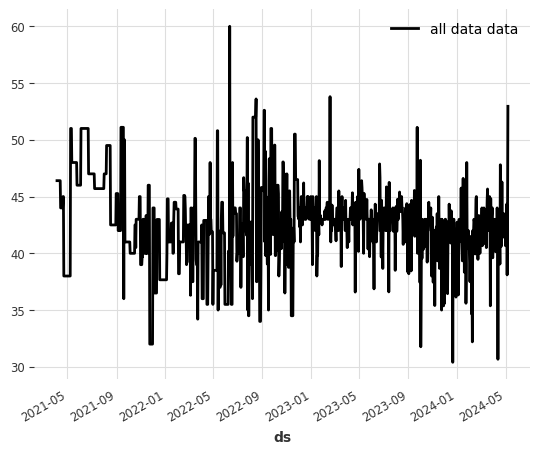

In [ ]:
time_df, train, test = TimeSeriesDataProcessor(data=time_data, source_data="polls").process_data(source_data="polls")

In [ ]:
INPUT_LENGTH = 720
OUTPUT_LENGTH = 120

INPUT_LENGTH, OUTPUT_LENGTH

(720, 120)

In [ ]:
scaled_pred_nhits = nhits.predict(n=362)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nhits[-1]

<TimeSeries (DataArray) (ds: 1, component: 1, sample: 1)>
array([[[0.37543774]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 2025-01-04
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

naive_seasonal MAE: 2.670370255951778
ARIMA MAE: 2.1939836699325386
SARIMA MAE: 2.316357652637483


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 4.7 K 
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

BlockRNN MAE: 1.8994986293680196


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.7 M 
---------------------------------------------------
1.3 M     Trainable params
369 K     Non-trainable params
1.7 M     Total params
6.791     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NHiTS MAE: 2.1717123715585873


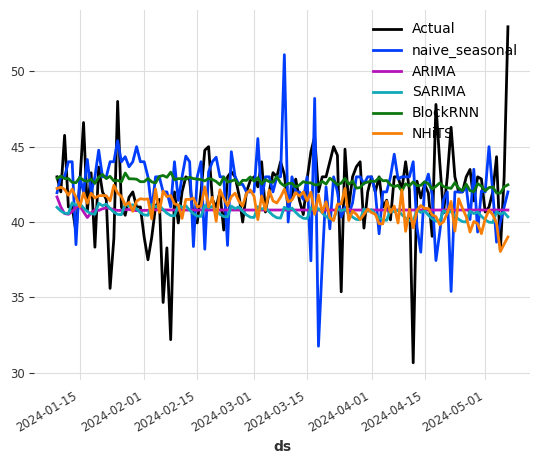

In [ ]:
from darts import TimeSeries
from darts.models import (NaiveSeasonal, ARIMA, ExponentialSmoothing, TransformerModel, RNNModel, BlockRNNModel, NHiTSModel)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae

import pandas as pd

model_config = {
    "naive_seasonal": {"model": NaiveSeasonal(K=168), "input_length": None, "output_length": None},
    "ARIMA": {"model": ARIMA(), "input_length": 720, "output_length": 120},
    "SARIMA": {"model": ExponentialSmoothing(), "input_length": 720, "output_length": 120},
    # "Transformer": {"model": TransformerModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 180},
    "BlockRNN": {"model": BlockRNNModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 120},
    "NHiTS": {"model": NHiTSModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 120}
}

def scale_data(train_data):
    scaler = Scaler()
    scaled_train = scaler.fit_transform(train_data)
    return scaler, scaled_train

def train_and_predict(model, train_data, n_pred, scaler=None):
    if scaler:
        train_data = train_data.astype('float32')
    model.fit(train_data)
    prediction = model.predict(n_pred)
    if scaler:
        prediction = scaler.inverse_transform(prediction)
    return prediction

def plot_and_evaluate(test_data, prediction, model_name):
    prediction.plot(label=model_name)
    error = mae(test_data, prediction)
    print(f"{model_name} MAE: {error}")


test.plot(label='Actual')
for model_name, config in model_config.items():
    if model_name == "naive_seasonal":
        pred_naive = train_and_predict(config['model'], train, 120)
        plot_and_evaluate(test, pred_naive, model_name)
    else:
        scaler, scaled_train = scale_data(train)
        pred = train_and_predict(config['model'], scaled_train, 120, scaler)
        plot_and_evaluate(test, pred, model_name)


In [ ]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)
scaled_train = scaled_train.astype('float32')

blockrnn = BlockRNNModel(
    input_chunk_length=720,
    output_chunk_length=180)

blockrnn.fit(
    scaled_train,
    epochs=100,)

forecasts = blockrnn.predict(n=303)

point_estimates = train_scaler.inverse_transform(forecasts)
point_estimates[-2]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 4.7 K 
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (ds: 1, component: 1, sample: 1)>
array([[[41.305233]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 2024-11-05
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### III. Approval Ratings Forecasting

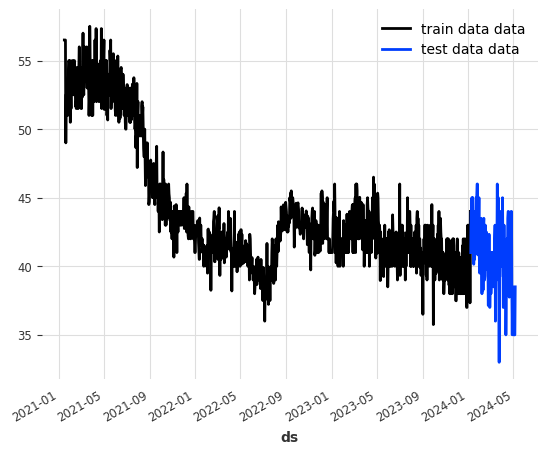

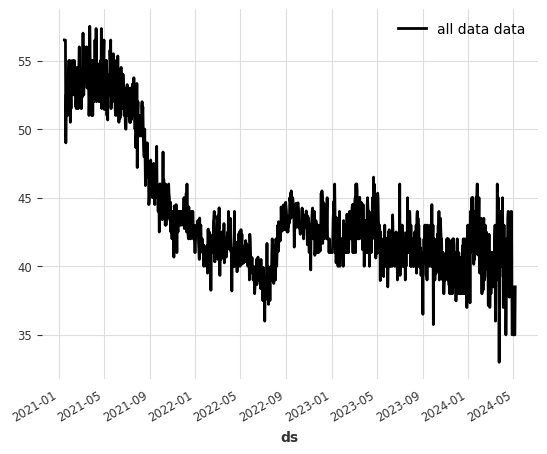

In [ ]:
appr_data = pd.read_csv('approval_polls.csv')
appr_df, train_appr, test_appr = TimeSeriesDataProcessor(data=appr_data, source_data="approval").process_data(source_data="approval")

naive_seasonal MAE: 2.4214962962962967
ARIMA MAE: 2.254009442534622
SARIMA MAE: 2.474666210164519


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 4.7 K 
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

BlockRNN MAE: 2.2580034227159294


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.7 M 
---------------------------------------------------
1.3 M     Trainable params
369 K     Non-trainable params
1.7 M     Total params
6.791     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NHiTS MAE: 2.3415606092664936


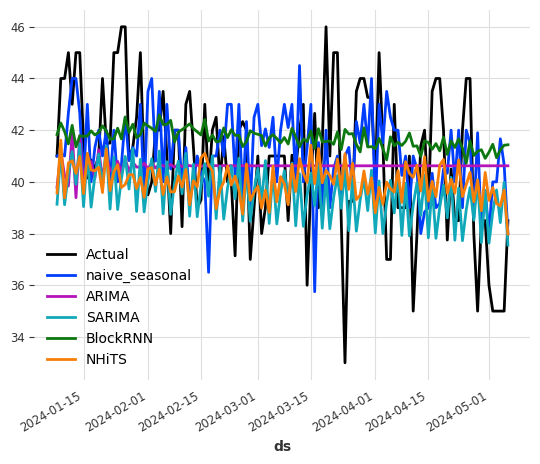

In [ ]:
###

from darts import TimeSeries
from darts.models import (NaiveSeasonal, ARIMA, ExponentialSmoothing, TransformerModel, RNNModel, BlockRNNModel, NHiTSModel)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae

import pandas as pd

model_config = {
    "naive_seasonal": {"model": NaiveSeasonal(K=168), "input_length": None, "output_length": None},
    "ARIMA": {"model": ARIMA(), "input_length": 720, "output_length": 120},
    "SARIMA": {"model": ExponentialSmoothing(), "input_length": 720, "output_length": 120},
    # "Transformer": {"model": TransformerModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 180},
    "BlockRNN": {"model": BlockRNNModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 120},
    "NHiTS": {"model": NHiTSModel(input_chunk_length=720, output_chunk_length=180), "input_length": 720, "output_length": 120}
}

def scale_data(train_data):
    scaler = Scaler()
    scaled_train = scaler.fit_transform(train_data)
    return scaler, scaled_train

def train_and_predict(model, train_data, n_pred, scaler=None):
    if scaler:
        train_data = train_data.astype('float32')
    model.fit(train_data)
    prediction = model.predict(n_pred)
    if scaler:
        prediction = scaler.inverse_transform(prediction)
    return prediction

def plot_and_evaluate(test_data, prediction, model_name):
    prediction.plot(label=model_name)
    error = mae(test_data, prediction)
    print(f"{model_name} MAE: {error}")


test_appr.plot(label='Actual')
for model_name, config in model_config.items():
    if model_name == "naive_seasonal":
        pred_naive = train_and_predict(config['model'], train_appr, 120)
        plot_and_evaluate(test_appr, pred_naive, model_name)
    else:
        scaler, scaled_train = scale_data(train_appr)
        pred = train_and_predict(config['model'], scaled_train, 120, scaler)
        plot_and_evaluate(test_appr, pred, model_name)


In [ ]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train_appr)
scaled_train = scaled_train.astype('float32')

nhits = NHiTSModel(
    input_chunk_length=INPUT_LENGTH,
    output_chunk_length=OUTPUT_LENGTH,
    random_state=42)

nhits.fit(
    scaled_train,
    epochs=100,)

forecasts = nhits.predict(n=303)

point_estimates = train_scaler.inverse_transform(forecasts)
point_estimates[-1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.7 M 
---------------------------------------------------
1.3 M     Trainable params
369 K     Non-trainable params
1.7 M     Total params
6.715     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (ds: 1, component: 1, sample: 1)>
array([[[39.267643]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 2024-11-05
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# data on voter approval of economy during year of incumbent president's election

headers = pd.read_csv('econ_approval.csv', nrows=0)
use_columns = headers.columns[1:]

econ_confidence = pd.read_csv('econ_approval.csv', usecols=use_columns)

econ_confidence = econ_confidence.transpose()

econ_confidence = econ_confidence[:-1]

new_column_names = ['old_sep', 'old_oct', 'old_nov', 'old_dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'final']
econ_confidence.columns = new_column_names

econ_confidence.iat[0, 14] = -20.0
econ_confidence.iat[6, 6] = (56+36)/2
econ_confidence.iat[7, 6] = 1.0
econ_confidence.iat[8, 6] = (-39.0 + -21.0)/2
econ_confidence.iat[8, 14] = -37.0

econ_confidence = econ_confidence.iloc[::-1]

econ_confidence['new_mar'] = (econ_confidence['mar'] + 100) / 2 # changing positive-negative voter approval to 0-100 scale
econ_confidence['new_final'] = (econ_confidence['final'] + 100) / 2

new_conf = econ_confidence[['mar', 'final']]
new_conf = new_conf[:-1]

new_conf['march_approval'] = (new_conf['mar'] + 100) / 2
new_conf['final_approval'] = (new_conf['final'] + 100) / 2
# new_conf['ev'] = [168, 379, 266, 286, 173, 332, 227, 232]
# new_conf['ev_pct'] = new_conf['ev'] / 5.38

inc_popvote_values = [0.375, 0.492, 0.484, 0.507, 0.457, 0.511, 0.482, 0.468]
new_conf['inc_popvote'] = inc_popvote_values
new_conf['inc_popvote'] = new_conf['inc_popvote'] * 100
new_conf = new_conf.reset_index(drop=True)

import statsmodels.api as sm

X = new_conf['final_approval']
X = sm.add_constant(X)
y = new_conf['inc_popvote']

model = sm.OLS(y, X).fit()

print(model.summary())

# econ_approval_estimate = 41.1201 + 0.1292 * 40

econ_approval_estimate

                            OLS Regression Results                            
Dep. Variable:            inc_popvote   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.337
Date:                Fri, 10 May 2024   Prob (F-statistic):              0.177
Time:                        21:33:28   Log-Likelihood:                -21.200
No. Observations:                   8   AIC:                             46.40
Df Residuals:                       6   BIC:                             46.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             41.1201      4.216      9.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


46.2881

In [ ]:
# inflation data

cpi = pd.read_csv('cpi_data.csv')

cpi['year'] = cpi['DATE'].astype(str).str[:4]

cpi['year'] = pd.to_numeric(cpi['year'])

cpi.rename(columns={'FPCPITOTLZGUSA': 'inflation'}, inplace=True)
cpi.rename(columns={'DATE': 'date'}, inplace=True)

cpi = cpi[cpi['year'] >= 1992]

cpi = cpi[cpi['year'] % 4 == 0]

cpi['inc_popvote'] = inc_popvote_values
cpi['inc_popvote'] = cpi['inc_popvote'] * 100

cpi = cpi.reset_index(drop=True)

cpi

# regression

X = cpi['inflation']
X = sm.add_constant(X)
y = cpi['inc_popvote']

model = sm.OLS(y, X).fit()

# print(model.summary())

inflation_estimate = 50.0148 - (1.1029 * 3.5)

inflation_estimate

                            OLS Regression Results                            
Dep. Variable:            inc_popvote   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                 -0.097
Method:                 Least Squares   F-statistic:                    0.3784
Date:                Fri, 10 May 2024   Prob (F-statistic):              0.561
Time:                        21:21:08   Log-Likelihood:                -22.272
No. Observations:                   8   AIC:                             48.54
Df Residuals:                       6   BIC:                             48.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0148      4.847     10.319      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


46.154650000000004

In [ ]:
# gdp data

gdp = pd.read_excel('gdp_data.xls')

first_row = gdp.iloc[1:2]

first_row

new_gdp = first_row.transpose()

new_gdp = new_gdp.drop(new_gdp.index[0])

new_gdp.columns = ['gdp_change']

df = pd.DataFrame({'year': range(1980, 2030)})

num_rows = len(new_gdp)
new_gdp['year'] = range(1980, 1980 + num_rows)

new_gdp = new_gdp[(new_gdp['year'] >= 1992) & (new_gdp['year'] <= 2020) & (new_gdp['year'] % 4 == 0)]

new_gdp['inc_popvote'] = inc_popvote_values
new_gdp['inc_popvote'] = new_gdp['inc_popvote'] * 100

new_gdp = new_gdp.reset_index(drop=True)

new_gdp

new_gdp['gdp_change'] = pd.to_numeric(new_gdp['gdp_change'], errors='coerce')

# regression

X = new_gdp['gdp_change']
X = sm.add_constant(X)
y = new_gdp['inc_popvote']

model = sm.OLS(y, X).fit()

# print(model.summary())

gdp_estimate = 46.9890 + (0.0981 * 2.7)

gdp_estimate

                            OLS Regression Results                            
Dep. Variable:            inc_popvote   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.164
Method:                 Least Squares   F-statistic:                   0.01526
Date:                Fri, 10 May 2024   Prob (F-statistic):              0.906
Time:                        21:29:22   Log-Likelihood:                -22.506
No. Observations:                   8   AIC:                             49.01
Df Residuals:                       6   BIC:                             49.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.9890      2.372     19.807      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


47.25387

In [ ]:
# unemployment rate

ue = pd.read_csv('UNRATE.csv')

ue['year'] = ue['DATE'].astype(str).str[:4]

ue['year'] = pd.to_numeric(ue['year'])

ue = ue[(ue['year'] % 4 == 0)]

ue.rename(columns={'UNRATE': 'ue_rate'}, inplace=True)

ue = ue.reset_index(drop=True)

ue['inc_popvote'] = inc_popvote_values

ue['inc_popvote'] = ue['inc_popvote'] * 100

ue

# regression

X = ue['ue_rate']
X = sm.add_constant(X)
y = ue['inc_popvote']

model = sm.OLS(y, X).fit()

print(model.summary())

ue_estimate = 52.0872 - (0.7939 * 3.9)

ue_estimate

                            OLS Regression Results                            
Dep. Variable:            inc_popvote   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.5271
Date:                Fri, 10 May 2024   Prob (F-statistic):              0.495
Time:                        21:32:55   Log-Likelihood:                -22.179
No. Observations:                   8   AIC:                             48.36
Df Residuals:                       6   BIC:                             48.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.0872      6.914      7.533      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


48.990990000000004

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
